# Flujo de trabajo Bayesiano {#sec-Bayesian-Worflow}

In [1]:
#| code-fold: true

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

# De datos y suposiciones a insights

Usamos datos para comprender el mundo que nos rodea, lo que podría consistir en revelar el origen del universo, predecir cuándo debemos plantar y cuándo cosechar, o cómo hacer sugerencias de productos útiles para mantener a los clientes interesados y comprando nuestros productos. Sin embargo, el mundo suele ser un lugar complejo y, por lo tanto, los datos deben procesarse e interpretarse para que sean útiles. Una forma de interpretar los datos es construir modelos. Los modelos son útiles porque nos permiten incorporar suposiciones y evaluarlas.

Los modelos funcionan como ficciones científicas; mapas que nos ayudan a navegar relaciones complejas. Por lo general (aunque no siempre), los modelos no son el objeto de interés principal, sino que son andamios que proporcionan un marco estructurado para comprender e interpretar datos.

Al discutir estadística Bayesiana se suele hacer en torno a modelos de probabilidad. Tomamos algunos priors, algunos likelihoods, que luego mezclamos con datos siguiendo como receta el Teorema de Bayes, y Voila!, somos bayesianos! 

Esta descripción no es incorrecta, simplemente no refleja muchos de los aspectos prácticos de la estadística Bayesiano (o del modelado en general). Lo que sucede es que muchos de esos aspectos prácticos no han sido completamente formalizados (como si lo ha sido el proceso de inferencia). Incluso para varios de esos aspectos, no tenemos aún buenas herramientas o incluso no tenemos aún buenos marcos conceptuales.

## El flujo de trabajo bayesiano

La siguiente figura muestra un esquema de un flujo de trabajo bayesiano. Podemos ver que hay muchos pasos. Necesitamos todos estos pasos porque los modelos son sólo elucubraciones de nuestra mente sin garantía de ayudarnos a comprender los datos. Primero debemos ser capaces de construir un modelo y luego comprobar su utilidad y, si no es lo suficientemente útil, seguir trabajando o, a veces, dejar de intentarlo. Es posible que también hayas notado el paso "evaluar muestras". Necesitamos esto porque, normalmente, utilizamos métodos computacionales para resolver modelos bayesianos, los cuales solos proveen garantías asimptóticas. 

![Un flujo de trabajo bayesiano. Las líneas continuas muestran un flujo de trabajo lineal desde la formulación del problema hasta el resumen de los resultados. Las líneas de puntos indican que los flujos de trabajo pueden ser no lineales y podemos omitir pasos o volver a pasos anteriores.](img/Bayesian_workflow.png)

Diseñar un modelo adecuado para una tarea de análisis de datos determinada generalmente requiere una combinación de experiencia estadística, conocimiento del dominio, comprensión de las herramientas computacionales y usualmente mucha perseverancia. Rara vez obtenemos el modelo queremos en un solo paso. Es similar a escribir un programa de computadora. Dificilmente no cometamos errores. Incluso los programas muy cortos requieren algo de prueba y error. Por lo general, es necesario probar, depurar y perfeccionar y, a veces, cambiar de enfoque . Lo mismo ocurre con los modelos estadísticos; después de todo, podemos ver los modelos estadísticos como software generador de datos.

En las siguientes secciones vamos a discutir algunos de los pasos del flujo de trabajo Bayesiano. Y al final vamos a describir un resumen de un trabajo Bayesiano. La mejor forma de lograr familiaridad con el flujo de trabajo bayesiano y los sub-flujos es resolviendo problemas.

## Pruebas predictivas a priori

La distribución predictiva a priori se define como:


$$
p(y^\ast) =  \int_{\Theta} p(y^\ast \mid \theta) \; p(\theta) \; d\theta
$$

donde $y^\ast$ representa datos no observados pero potencialmente observables, al menos de acuerdo a nuestro modelo. Los datos generados son predictivos ya que son los datos que el modelo esperara ver, es decir son datos no observados pero potencialmente observables. 

Lo que estamos haciendo es marginalizando el likelihood al integrar sobre todos los valores posibles del prior. Por lo tanto, desde la perspectiva de nuestro modelo, estamos describiendo la distribución marginal de los datos, es decir independientemente de los parámetros. En otros palabras estamos generando predicciones del modelo "antes" de ver los datos. Esta distribución representa lo que el modelo "cree" sobre la cantidad modelada.

Obtener esta distribución de forma analítica no siempre es sencillo, pero si lo es computacionalmente, siempre y cuando podamos escribir un modelo en un PPL. Podemos generar muestras de esta distribución según el siguiente procedimiento:

1. Elegimos un valor de $\theta$ de acuerdo a la distribución a priori $p(\theta \mid y)$
2. Fijamos $\theta$ en la distribución que usamos como likelihood $p(y^\ast \mid \theta)$ y generamos una muestra aleatoria
3. Repetimos desde 1, tantas veces como muestras necesitemos

Uno de los usos prácticos de esta distribución es evaluar el modelo. A grandes rasgos esto se puede realizar generando datos a partir de la distribución predictiva a priori y comparándolos con nuestro conocimiento de domino. Es común que las comparaciones sean visuales y semi-cuantitativas, es decir buscamos acuerdos razonables. Por ejemplo podemos hacernos preguntas como ¿La mayor parte de la distribución simulada está en un rango razonable? ¿Existen valores extremos? Es recomendable NO comparar con los datos observados, en cambio usar valores de referencia. Los valores de referencia son datos empíricos u observaciones históricas, normalmente serán valores mínimos, máximos o esperados.

### Predadores y presas

Estamos interesados en modelar la relación entre las masas de los masas de organimos que son presas de otros organismos, como las masas varian en órdenes de magnitud desde una célula de 1e-14 gramos a una ballena azul de 1.5e8 gramos, es conveniente trabajar en una escala logarítmica. Entonces un modelo podría ser

\begin{align}
    \mu =& Normal(\cdots, \cdots) \\
    \sigma =& HalfNormal(\cdots) \\
    log(masas) =& Normal(\mu, \sigma)
\end{align}

Para definir los valores del prior, podriamos definir el modelo con algunos priors y ver que implican estos priors en la escala de los datos. Para muestrear de la predictiva a priori usamos `pm.sample_prior_predictive()` en vez de `sample` y necesitamos definir observaciones "dummy". Esto es necesario para indicar cual es el likelihood y para controlar el tamaño de cada distribución predicha.

In [2]:
pp_mass = pd.read_csv("datos/pp_mass.csv")
pp_mass["predator_log"] = np.log(pp_mass["predator"])
pp_mass["prey_log"] = np.log(pp_mass["prey"])

# valores de referencia en escala lof
refs = {"Planeta Tierra":np.log(5.97e+27),
        "Ballena Azul":np.log(1.5e8), 
        "Célula más pequeña":np.log(1e-14)}

In [3]:
with pm.Model() as model:
    α = pm.Normal("α", 0, 100)
    β = pm.Normal("β", 0, 100)
    σ = pm.HalfNormal("σ", 5)
    presa = pm.Normal("presa", α + β * pp_mass["prey_log"], σ, observed=pp_mass["predator_log"])
    idata = pm.sample_prior_predictive(samples=100)


Sampling: [presa, α, β, σ]


Podemos ver que el idata no tiene grupo `posterior`, pero si tiene `prior` y `prior_predictive`

In [4]:
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

Nuestro modelo tiene priors tan vagos que todos los valores que ni siquiera podemos distinguir nuestro valores de referencia.

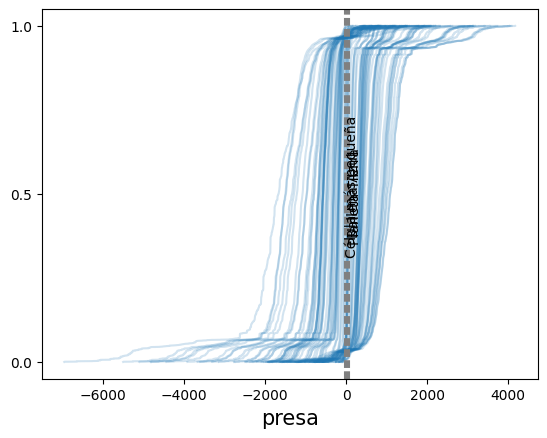

In [5]:
ax = az.plot_ppc(idata, group="prior", kind="cumulative", mean=False, legend=False)

for key, val in refs.items():
    ax.axvline(val, ls="--", color="0.5")
    ax.text(val-7, 0.5-(len(key)/100), key, rotation=90)

In [6]:
with pm.Model() as model:
    α = pm.Normal("α", 0, 1)
    β = pm.Normal("β", 0, 1)
    σ = pm.HalfNormal("σ", 5)
    presa = pm.Normal("presa", α + β * pp_mass["prey_log"], σ, observed=pp_mass["predator_log"])
    idata = pm.sample_prior_predictive(samples=100)

Sampling: [presa, α, β, σ]


Con estos nuevos priors todavía tenemos algunos valores sin sentido, pero al menos la mayor parte de la masa de nuestras predicciones está dentro de rangos razonables.

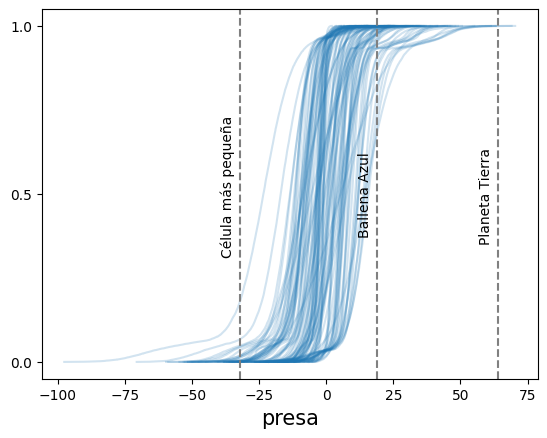

In [7]:
ax = az.plot_ppc(idata, group="prior", kind="cumulative", mean=False, legend=False)

for key, val in refs.items():
    ax.axvline(val, ls="--", color="0.5")
    ax.text(val-7, 0.5-(len(key)/100), key, rotation=90)

PreliZ nos permite hacer algo similar pero de forma interactiva

In [8]:
def pp_model(α_μ=0, α_σ=100, β_μ=0, β_σ=100, σ_σ=5):
    α = pz.Normal(α_μ, α_σ).rvs()
    β = pz.Normal(β_μ, β_σ).rvs()
    σ = pz.HalfNormal(σ_σ).rvs()
    prey = pz.Normal(α + β * pp_mass.predator_log, σ).rvs()
    return prey

refs = {"Earth":np.log(5.97e+27), "Blue whale":np.log(1.5e8), "Smallest cell":np.log(1e-14)}
pz.predictive_explorer(pp_model, references=refs)

## Pruebas predictivas a posteriori

Se define como 

$$
p(\tilde{y}  \mid  y) = \int p(\tilde{y} \mid \theta) p(\theta \mid y) d\theta 
$$

donde $\tilde{y}$ representa los datos generados por un modelo una vez obtenido el _a posteriori_. Es decir, las predicciones del modelo. Es similar a la distribución predictiva a priori, pero esta vez integramos sobre los valores _a posteriori_ de $\theta$

Computacionalmente podemos generar muestras de esta distribución según el siguiente procedimiento:

1. Elegimos un valor de $\theta$ de acuerdo a la distribución a posteriori $p(\theta \mid y)$
2. Fijamos $\theta$ en la distribución que usamos como likelihood $p(\tilde{y} \mid \theta)$ y generamos una muestra aleatoria
3. Repetimos desde 1, tantas veces como muestras necesitemos

Las pruebas predictivas a posteriori son usadas de forma muy extendida para evaluar un modelo. En este caso SI es común compara contra los datos observados. Al comparar con los datos que se usaran para ajustar el modelo este tipo de pruebas son una forma de evaluación de la consistencia interna de un modelo. Es decir, de mínima esperamos que un modelo sea capaz de reproducir los datos usados para ajustarlo.

In [9]:
accidentes = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                       3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                       2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                       1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                       0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                       3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
años = np.arange(1851, 1962)

In [10]:
with pm.Model() as modelo_cat:
    pc = pm.DiscreteUniform("pc", lower=años.min(), upper=años.max())

    t_0 = pm.Exponential("t_0", 1)
    t_1 = pm.Exponential("t_1", 1)

    tasa = pm.Deterministic("tasa", pm.math.switch(pc >= años, t_0, t_1))

    acc = pm.Poisson("acc", tasa, observed=accidentes)
    idata_cat = pm.sample(1000, random_seed=1791, progressbar=False)
    idata_cat.extend(pm.sample_posterior_predictive(idata_cat, progressbar=False))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [pc]
>NUTS: [t_0, t_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [acc]


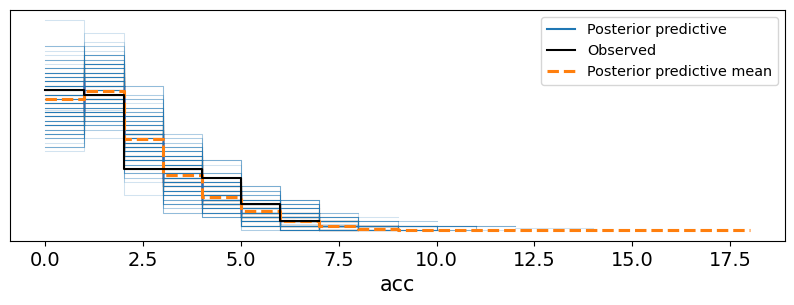

In [11]:
ax = az.plot_ppc(idata_cat, figsize=(10, 3), num_pp_samples=200)
ax.set_xlabel("acc");


### Valores p Bayesianos


Un valor-p Bayesiano se define como:


$$
\text{valor-p Bayesiano} \triangleq p(T_{\text{sim}} \le T_{\text{obs}} \mid \tilde y)
$$

Donde $T$ es un estadístico sumário como la media, mediana, desviación estándar o lo que se desee comparar, que se calcula para los datos observados $T_{\text{obs}}$ y para los datos simulados $T_{\text{sim}}$. 

Si los valores observados coinciden con los predichos, el valor esperado será 0,5. Es decir, la mitad de las predicciones estarán por debajo de las observaciones y la otra mitad por encima.



> Para aquellos que están familiarizados con los valores p y su uso en estadística frecuentista,
hay un par de aclaraciones. Lo que hay de bayesiano en estos valores p es que
NO estamos utilizando una distribución muestral sino la distribución predictiva posterior.
Además, no estamos haciendo una prueba de hipótesis nula ni tratando de declarar
que una diferencia es “significativa”. 

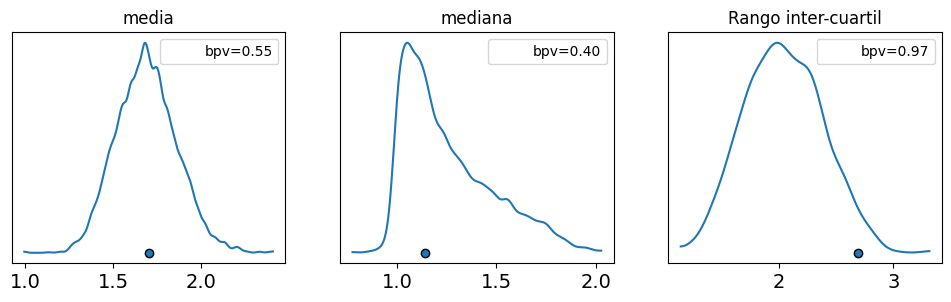

In [12]:
_, ax = plt.subplots(1, 3, figsize=(12, 3))

def iqr(x, a=-1):
    """interquartile range"""
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

az.plot_bpv(idata_cat, kind="t_stat", t_stat="mean", ax=ax[0])
az.plot_bpv(idata_cat, kind="t_stat", t_stat="median", ax=ax[1])
az.plot_bpv(idata_cat, kind="t_stat", t_stat=iqr, ax=ax[2])
ax[0].set_title("media")
ax[1].set_title("mediana")
ax[2].set_title("Rango inter-cuartil");

Un caso especial se da al comparar si los valores simulados son menores que los observados, es decir

$$
p(\tilde y \le y_{\text{obs}} \mid y)
$$

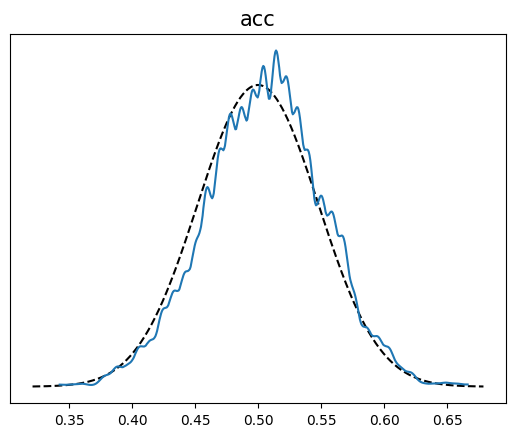

In [13]:
az.plot_bpv(idata_cat, kind="p_value");

Otra posibilidad es realizar la comparación por observación.

$$
p(\tilde y_i \le y_i \mid y)
$$

Esto se suele llamar valor-p marginal y la distribución ideal es uniforme estándar.

La linea blanca en la siguiene figura representa el valor ideal y la banda gris la desviación esperada dado el tamaño de los datos. Los valores de x se pueden interpretar como cuantiles, es decir los valores centrales representan el "seno" de la distribución y los valores extremos las "colas".

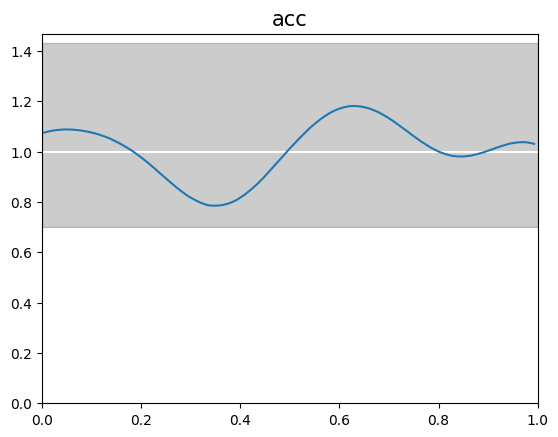

In [14]:
az.plot_bpv(idata_cat);


Por qué esperamos una distribución uniforme? Debido a una propiedada llamada transformada integral de probabilidad (PIT por su sigla en inglés). También llamada a veces universalidad de la uniforme.

Dada una variable aleatoria continua $X$ y CDF $F_X$ podemos computar una variable aleatoria $Y$ con distribución uniforme estándard haciendo.

$$
Y = F_X (X)
$$

Es decir si tomamos una variable aleatoria $X$ y le aplicamos su propia CDF, la transformamos en $Y \sim \mathcal{U}[0, 1]$. Empiricamente podemos ver esto haciendo:

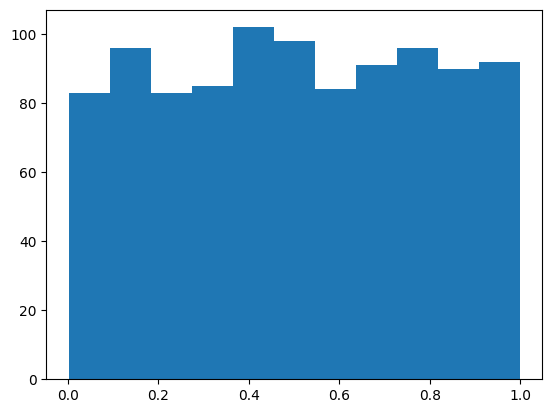

In [15]:
dist = pz.Normal(0, 1)  # Probar con otras distribuciones
plt.hist(dist.cdf(dist.rvs(1000)), bins="auto");

Si desconocemos $F_X$, pero contamos con muestras de $X$, podemos usar la CDF empírica que es lo que estamos haciendo al calcular el valor-p marginal.


In [16]:
dist = pz.Normal(0, 1)  # Probar con otras distribuciones
pred_f = np.exp(dist.rvs(1000))**0.3
obs_f = np.exp(dist.rvs(1000))**0.3

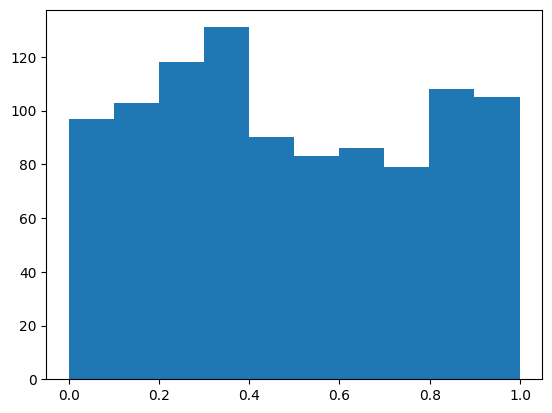

In [17]:
pit = []
for m in obs_f:
    pit.append(np.mean(pred_f <= m))
    
plt.hist(pit);

## Comparación de modelos

## El equilibro entre simplicidad y exactitud

Al elegir entre explicaciones alternativas, existe un principio conocido como la navaja de Occam. En lineas muy generales este principio establece que dadas dos o más explicaciones equivalentes para el mismo fenómeno, la más simple es la explicación preferida. Un criterio común de simplicidad es la cantidad de parámetros de un modelo.

Otro factor que generalmente debemos tener en cuenta al comparar modelos es su exactitud, es decir, qué tan bueno es un modelo ajustando los datos. Según este criterio si tenemos dos (o más) modelos y uno de ellos explica los datos mejor que el otro, entonces ese es el modelo preferido. 

Intuitivamente, parece que al comparar modelos, tendemos a preferir aquellos que mejor ajusten los datos y aquellos que sean más simples. ¿Pero que hacer si estos dos principios se contraponen? O de forma más general, ¿Existe una forma cuantitativa de contemplar ambas contribuciones? La respuesta corta es que si. De hecho hay más de una forma de hacerlo. Pero antes veamos un ejemplo a fin de generar mayor intuición.


### Muchos parámetros (pueden) conducir a sobreajuste

Vamos a comenzar por combinar polinomios cada vez más complejos en un conjunto de datos muy simple. En lugar de utilizar la maquinaria Bayesiana, usaremos la aproximación de mínimos cuadrados para ajustar modelos lineales. 

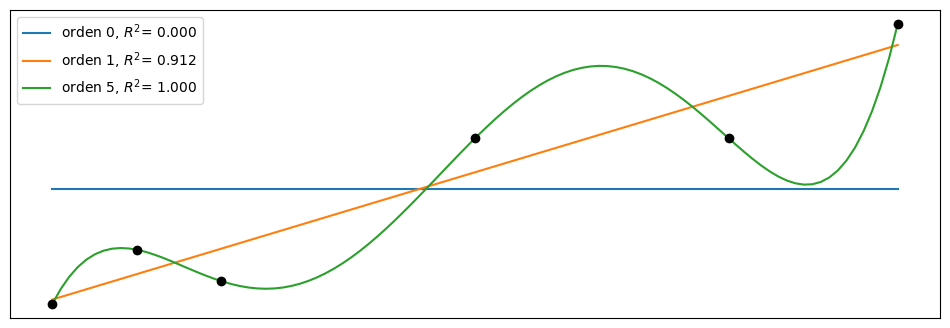

In [18]:
#| code-fold: true

_, ax = plt.subplots(1, 1, figsize=(12, 4))


x0 = np.array([4., 5., 6., 9., 12, 14.])
y0 = np.array([4.2, 6.1, 5., 10., 10, 14.])

order = [0, 1, 5]
ax.plot(x0, y0, 'ko', zorder=3)


ax.set_yticks([])
ax.set_xticks([])

x_n = np.linspace(x0.min(), x0.max(), 100)
ps = []
for i in order:
    p = np.polynomial.Polynomial.fit(x0, y0, deg=i)
    ps.append(p)
    yhat = p(x0)
    ybar = np.mean(y0)
    ss_regression = np.sum((yhat-y0)**2)
    ss_total = np.sum((ybar-y0)**2)
    r2 = 1 - ss_regression / ss_total
    ax.plot(x_n, p(x_n), label=f'orden {i}, $R^2$= {r2:.3f}')

    
ax.legend(loc=2);

De la figura anterior podemos ver que el aumento de la complejidad del modelo se acompaña de una mayor exactitud reflejada en el coeficiente de determinación R². De hecho, podemos ver que el polinomio de orden 5 se ajusta perfectamente a los datos, obteniendo un R²=1. 

¿Por qué el polinomio de grado 5 puede capturar los datos sin perder uno solo de ellos? La razón es que tenemos el mismo número de parámetros que de datos es decir 6. Por lo tanto, el modelo está actuando como una forma alternativa de expresar los datos. El modelo no está *aprendiendo* algo sobre los datos, ¡Está memorizando los datos! A partir de este simple ejemplo, podemos ver que un modelo con mayor ajuste no siempre es lo ideal.


Ahora agregaremos dos datos nuevos y sin volver a ajustar los modelos veremos como cambia el R². Se puede ver que al modelo lineal le va mejor en este caso que al polinomial.

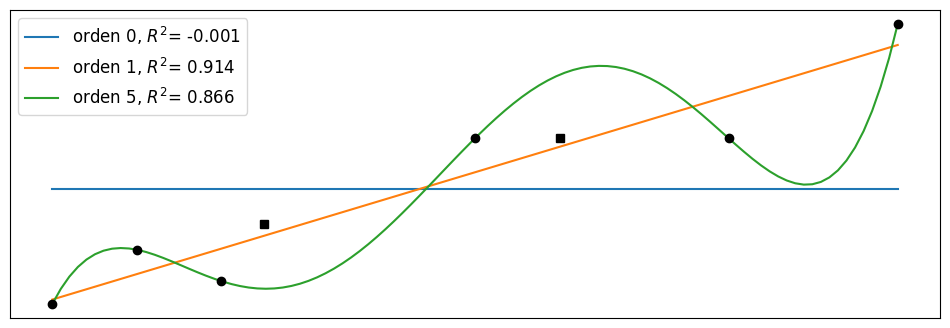

In [19]:
#| code-fold: true

_, ax = plt.subplots( figsize=(12, 4))
x_ = np.array([6.5, 10])
y_ = np.array([7, 10])

ax.plot(x0, y0, 'ko', zorder=3)
ax.plot(x_, y_, 'ks', zorder=3)

ax.set_yticks([])
ax.set_xticks([])

x1 = np.concatenate((x0, x_))
y1 = np.concatenate((y0, y_))

for idx, i in enumerate(order):
    yhat = ps[idx](x1)
    ybar = np.mean(y1)
    ss_regression = np.sum((yhat-y1)**2)
    ss_total = np.sum((ybar-y1)**2)
    r2 = 1 - ss_regression / ss_total
    ax.plot(x_n, ps[idx](x_n), label=f'orden {i}, $R^2$= {r2:.3f}')

    
ax.legend(loc=2, fontsize=12);

Cuando un modelo ajusta muy bien, el conjunto de datos utilizado para aprender los parámetros de ese modelo, pero muy mal otros conjuntos de datos, decimos que tenemos sobreajuste (overfitting). Este es un problema muy común al analizar datos.

Una forma muy útil de pensar el sobreajuste es considerar que un conjunto de datos tiene dos componentes; la señal y el ruido. La señal es lo que queremos capturar (o aprender) de los datos. Si usamos un conjunto de datos es porque creemos que hay una señal allí, de lo contrario será un ejercicio fútil. El ruido, en cambio, no es útil y es el producto de los errores de medición, las limitaciones en la forma en que se generaron o capturaron los datos, la presencia de datos corruptos, etc. Un modelo sobreajusta cuando es tan flexible (para un conjunto de datos) que es capaz de _aprender_ el ruido. Esto tiene como consecuencia que la señal queda oculta.

Esta es una justificación práctica para la navaja de Occam. Y nos advierte que al menos en principio, siempre es posible crear un modelo tan complejo que explique todos los detalles, incluso los más irrelevantes. Tal como en el Imperio descripto por Borges, donde los cartógrafos alcanzaron tal nivel de sofisticación que crearon un mapa del Imperio cuyo tamaño era el del propio Imperio, y que coincidía punto por punto con él.

### Muy pocos parámetros conducen a un subajuste

Continuando con el mismo ejemplo pero en el otro extremo de complejidad, tenemos el modelo de orden 0. Este modelo es simplemente una Gaussiana disfrazada de modelo lineal. Este modelo solo es capaz de capturar el valor de la media de $y$, y es por lo tanto totalente indiferente a los valores de $x$. Decimos que este modelo ha subajustado los datos.

### Medidas de exactitud predictiva


_Todo debe hacerse tan simple como sea posible, pero no más simple_ es una cita que a menudo se atribuye a Einstein. Al igual que en una dieta saludable, al modelar tenemos que mantener un balance. Idealmente, nos gustaría tener un modelo que ni sub-ajuste ni sobre-ajuste los datos. De alguna forma hay que balancear simplicidad y bondad de ajuste.

En el ejemplo previo, es relativamente facil de ver que el modelo de orden 0 es _demasiado_ simple mientras que el modelo de orde 5 es _demasiado_ complejo. Pero que podemos decir de los otros dos modelos? Cómo podríamos establecer un ranking numérico de estos modelos? Para poder hacer esto necesitamos formalizar nuestra intuición sobre este balance entre simplicidad y exactitud

Veamos un par de términos que nos serán de utilidad.

* **Exactitud dentro de la muestra** (within-sample accuracy). La exactitud medida con los mismos datos usado para ajustar el modelo.
* **Exactitud fuera de la muestra** (out-of-sample accuracy). La exactitud medida con datos no usados para ajustar el modelo.

La exactitud dentro de la muestra será, en promedio, menor a la exactitud fuera de la muestra. Es por ello que usar la exactitud dentro de la muestra para evaluar un modelo en general conducirá a pensar que tenemos un mejor modelo de lo que realmente es. Utilizar la exactitud fuera de la muestra es por lo tanto una mejor idea para evitar engañarnos a nosotros mismos. Sin embargo, esta aproximación requiere dejar datos fuera del ajuste, lo cual es un lujo que en general no nos podemos dar. Ya que este es un problema central en el análisis de datos existen varias propuestas para abordarlo. Dos aproximaciones muy populares son:


* Validación cruzada: esta es una estrategia empírica basada en dividir los datos disponibles en subconjuntos separados que se utilizan para ajustar y evaluar de forma alternativa

* Criterios de información: este es un término general usado para referirse a varias expresiones que  aproximan la exactitud fuera de la muestra como la exactitud dentro de la muestra más un término que penaliza la complejidad del modelo.

### Validación cruzada

La validación cruzada es una solución simple y, en la mayoría de los casos, efectiva para comparar modelos. Tomamos nuestros datos y los dividimos en K porciones. Intentamos mantener las porciones más o menos iguales (en tamaño y, a veces, también en otras características, como, por ejemplo, un número igual de clases). Luego usamos K-1 porciones para entrenar el modelo y el resto para evaluarlo. Este proceso se repite sistemáticamente dejando, por cada iteración, una porción diferente fuera del conjunto de entrenamiento y usando esa porción como el conjunto de evaluación. Esto se repite hasta que hayamos completado K rondas de ajuste-evaluación. La exactitud del modelo será la del promedio a lo largo de las K rondas. Esto se conoce como validación cruzada K-fold. Por último, una vez que hemos relizado la validación cruzada, usamos todos los datos para ajustar por última vez nuestro modelo y este es el modelo que se utiliza para hacer predicciones o para cualquier otro fin.

<img src='img/cv.png' width=500 >

Cuando K es igual a la cantidad de puntos de datos, obtenemos lo que se conoce como _validación cruzada dejando uno afuera_ (LOOCV del inglés leave-one-out cross-validation). 

La validación cruzada es una práctica de rutina en _machine learning_. Y apenas hemos descripto los aspectos más esenciales de esta práctica. Para mayor información pueden leer [The Hundred-Page Machine Learning Book](http://themlbook.com/)  o [Python Machine Learning](https://www.amazon.com/Python-Machine-Learning-scikit-learn-TensorFlow-ebook/dp/B0742K7HYF/ref=dp_ob_title_def), by Sebastian Raschka, o [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) by Jake Vanderplas.

La validación cruzada es una idea muy simple y útil, pero para algunos modelos o para grandes cantidades de datos, el costo computacional de la validación cruzada puede estar más allá de nuestras posibilidades. Muchas personas han tratado de encontrar cantidades más simples de calcular que se aproximen a los resultados obtenidos con la validación cruzada o que funcionen en escenarios donde la validación cruzada no puede ser tan fácil de realizar. Y ese es el tema de la siguiente sección.

### Criterios de información


Los criterios de información son una colección de herramientas estrechamente relacionadas que se utilizan para comparar modelos en términos de la bondad del ajuste y de la complejidad del modelo. En otras palabras, los criterios de información formalizan la intuición que desarrollamos al comienzo del capítulo. 
La forma exacta en que se derivan estas cantidades tiene que ver con un campo conocido como [Teoría de la Información](http://www.inference.org.uk/mackay/itila/book.html).


Una forma intuitiva de medir qué tan bien un modelo se ajusta a los datos es calcular el error cuadrático medio entre los datos y las predicciones realizadas por el modelo:


$$\frac{1}{n} \sum_{i=1}^{n}  (y_i - \operatorname{E} (y_i \mid \theta))^2$$


$\operatorname{E} (y_i \mid \theta)$ es el valor predicho dados los parámetros estimados. Es importante notar que esto es esencialmente el promedio de la diferencia entre los datos observados y los predichos.
Tomar el cuadrado de los errores asegura que las diferencias no se cancelen y enfatiza grandes errores comparado con otros alternativas como por ejemplo calcular el valor absoluto.

El error cuadrático medio, puede resultarnos familiar ya que es muy popular. Pero si nos detenemos a reflexionar sobre esta cantidad veremos que en principio no tiene nada de especial y bien podríamos idear otras expresiones similares. Cuando adoptamos una aproximación probabilista vemos que una expresión más general (y *natural*) es la siguiente:

$$ \sum_{i=1}^{n} \log p(y_i \mid \theta)$$

Esto es, la suma (sobre $n$ datos) de los _likelihoods_ (en escala logarítmica). Esto es _natural_ por que al elegir un likelihood en un modelo estamos eligiendo implícitamente una métrica para evaluar el ajuste del modelo. Cuando $p(y_i \mid \theta)$ es una gaussiana entonces la suma de log-likelihood será proporcional al error cuadrático medio.

#### Criterio de información de Akaike 

Este es un criterio de información muy conocido y ampliamente utilizado fuera del universo Bayesiano y se define como:

$$AIC = -2 \sum_{i=1}^{n} \log p(y_i \mid \hat{\theta}_{mle}) + 2 k $$

Donde, k es el número de parámetros del modelo y $\hat{\theta}_{mle}$ es la estimación por máxima verosimilitud para $\theta$. Para el resto de nuestra discusión vamos a omitir la constante -2 y escribir 


$$AIC = \sum_{i=1}^{n} \log p(y_i \mid \hat{\theta}_{mle}) - k $$

De esta forma es más fácil ver que el criterio de Akaike es una maxima-verosimilitud penalizada (se hace más chica, se minimiza) mientras más parámetros tenga un modelo.Además, esta versión sin el -2 tiene una correspondencia más clara con otras expresiones que veremos a continuación.

Qué el número de parámetros sea un criterio válido de penalización es intutivo, ya que como vimos en el ejemplo anterior con los polinomios, un modelo con mayor número de parámetros es, en general, más flexible. Pero es importante destacar que el criterio de Akaike tiene una justificación teórica, no es que Akaike siemplemente pensó que usar $k$ era buena idea.


El criterio de AIC es muy útil, pero presenta problemas para modelos Bayesianos. Una de las razones es que no utiliza la distribución a posteriori de $\theta$ y, por lo tanto, descarta información. Además AIC, desde una pespectiva Bayesiana, asume que los priors son *planos* y, por lo tanto, AIC es incompatible con priors informativos y/o ligeramente informativos. Además, la cantidad de parámetros de un modelo no es una buena medida de la complejidad del mismo cuando se usan priors informativos o estructuras como la jerárquica. Agregar información a un modelo en su estructura, equivale a reducir la _cantidad efectiva de parámetros_, algo también conocido como *regularización*.

Podemos encontrar una expresión equivalente, pero mejor ajustada a modelos Bayesianos?

### WAIC

Como ya vimos en el criterio de Akaike, la bondad del ajuste viene dado por:

$$
\sum_{i=1}^{n} \log p(y_i \mid \hat{\theta}_{mle})
$$

Pero en estadística Bayesiana, NO tenemos una estimación puntual de $\theta$. Tenemos una distribución, por lo que deberíamos hacer:

$$
\sum_{i=1}^{n} \log
    \int \ p(y_i \mid \theta) \; p(\theta \mid y) d\theta
$$

Como en general no tenemos una expresión analitica para el posterior, $p(\theta \mid y)$, pero tenemos unas serie de muestras (como las obtenidas por MCMC), entonces podemos aproximar la integral por:

$$
\sum_i^n \log \left(\frac{1}{S} \sum_{s=1}^S p(y_i \mid \theta^s) \right)
$$

LLamaremos a esta cantidad ELPD, que es la sigla en inglés para valor esperado de la densidad log-predictiva. 

OK, ya tenemos como medir la bonda de ajuste. Ahora necesitamos un término que penalice la complejidad del modelo. Encontrar la expresión correcta para esto, requiere de trabajo, asi que la vamos a presentar sin justificar. Este nuevo criterio (la versión Bayesiana de Akaike) se llama Widely applicable information criterion:

$$WAIC = \sum_i^n \log \left(\frac{1}{S} \sum_{s=1}^S p(y_i \mid \theta^s) \right) - \sum_i^n  \left( V_{s=1}^S \log p(y_i \mid \theta^s) \right)$$


Donde el término de penalización viene dado por la varianza de los log-likelihoods sobre las $S$ muestras del posterior. Intuitivamente el término penaliza modelos que tengan mucha variabilidad en sus predicciones. Veamos como ejemplo un modelo lineal:

$$
Y = \alpha + \beta X
$$

Un modelo donde $\beta=0$ será menos flexible, ya que equivale a un modelo que solo tiene un parámetro, $alpha$. De forma un poco más sutil un modelo donde $\beta$ varía en un rango estrecho será menos flexible (más regularizado), que un modelo donde $\beta$ puede tomar cualquier valor.

### LOO y la validación cruzada (aproximada)


Existe otra alternativa para penalizar el término

$$
\sum_i^n \log \left(\frac{1}{S} \sum_{s=1}^S p(y_i \mid \theta^s) \right)
$$

Y es calcular

$$
\sum_{i}^{n} \log
    \left( \frac{1}{s}\sum_j^s \mathbin{\color{#E9692C}{p(y_i \mid \theta_{-i}^j)}} \right)
$$


donde $_{-i}$ quiere decir que dejamos la observación $i$ afuera. Una implementación Naive de esta estimación requiere que estimos tantas distribuciones a posteriori como datos tengamos, ya que para cada una de ellas eliminaremos una observación. Sin embargo, esto no es necesario ya que es posible estiamar $\color{#E9692C}{p(y_i \mid \theta_{-i}^j})$ usando **Muestreo de Importancia** (importance sampling).

Antes de seguir con nuestra agenda, necesitamos hacer un pequeño detour.

#### Muestreo de importancia

Esta es una técnica para estimar propiedades de una distribución de interés $f$, dado que solo tenemos muestras de una distribución $g$. Usar el muestreo de importancia tiene sentido, por ejemplo, cuando es más simple muestrear $g$ y no $f$. 

Si tenemos un conjunto de muestras de la variable aleatoria $X$ y podemos evaluar $g$ y $f$ puntualmente, podemos calcular los pesos de importancia como:

\begin{equation}
     w_i = \frac{f(x_i)}{g(x_i)}
\end{equation}

Computacionalmente queda de la siguiente manera:

\begin{itemize}
     \item Extraer $N$ muestras $x_i$ de $g$
     \item Calcular la probabilidad de cada muestra $g(x_i)$
     \item Evaluar $f$ sobre las $N$ muestras $f(x_i)$
     \item Calcular los pesos de importancia $w_i = \frac{f(x_i)}{g(x_i)}$
\end{itemize}

Una vez obtenidos los pesos $w_i$, podemos usarlos para estimar propiedades de $f$, su densidad, momentos, cuantiles, etc.

A continuación se muestre un bloque de código donde $g$ es una Normal y $f$ una Gamma y usamos muestreo de importacia para estimar la PDF de $f$. Este es solo un ejemplo didáctico, ya que en realidad sabemos como calcular la PDF de una Gamma. Pero en la práctica $f$ puede ser un objeto mucho más complejo.  

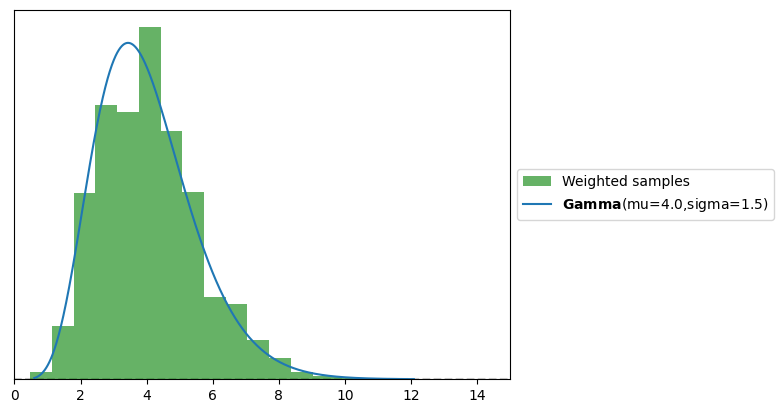

In [20]:
g = pz.Normal(0, 10)
samples = g.rvs(1000)
f = pz.Gamma(mu=4, sigma=1.5)

w = f.pdf(samples) / g.pdf(samples)

plt.hist(samples, bins=100, density=True, weights=w, alpha=0.6, color='g', label='Weighted samples')
plt.xlim(0, 15)


f.plot_pdf();

Al hacer muestreo de importancia mientras más similares sean $g$ y $f$ mejor serán los resultados. En la práctica las inferencias son más confiables cuando $g$ tiene un soporte mayor que $f$, es decir cuando es más "ancha", intuitivamente necesitamos que las muestras de $g$ cubran todo el soporte de $f$ (o al menos las regiones de densidad alta).

### Retomando

Ahora que tenemos una mejor idea de muestreo por importancia veamos como podemos usarlo. La distribución que conocemos es la distribución a posteriori, y la que queremos aproximar por muestreo de importancia es la distribución a posteriori dejando uno afuera $p(y_i \mid \theta_{-i}^j)$. Por lo que los pesos de importancia que nos interesa calcular son:

\begin{equation}
    w_i^j = \frac{p(\theta^j \mid y_{-i} )}{p(\theta^j \mid y)} \propto \frac{p(\theta) \prod_{i\not=-i}^n p(y_i \mid \theta)}{p(\theta) \prod_i^n p(y_i \mid \theta)} \propto \frac{1}{p(y_i \mid \theta^j)} 
\end{equation}

Es decir los términos comunes (y que por lo tanto se cancelan) entre numerador y denominador son todos menos el likelihood para la observación que queremos remover. Notese que los pesos son proporcionales y no están normalizados, pero esto no es un problema ya que se pueden normalizar simplemente dividiendo cada peso por la suma total de los pesos. 


Este resultado es una gran noticia, porque nos dice que es posible calcular el ELPD por validación cruzada dejando uno afuera, a partir de un solo ajuste de los datos! y que solo necesitamos los valores de los log-likelihoods, cuyo costo computacional es costo, en general, muy bajo. 

La trampa, por que siempre hay una trampa, es que es esperable que $p(\theta^j \mid y_{-i} )$ sea más "ancha" que $p(\theta^j \mid y)$, ya que es una distribución a posteriori estimada con una observación menos. Esto es lo contrario al caos ideal en muestreo por importancia. Para muchos casos puede que la diferencia no sea relevante, ya que eliminar una observación puede conducir a una distribución a posteriori practicamente equivalente. Pero en algunos casos la diferencia puede ser relativamente grande. Cuándo? Pues, mientras más "influyente" sea la observación. En términos de importance sampling esto se traduce en pesos con mayor importancia realativa y que por lo tanto tienen a dominar la estimación. 

Una forma de correguir esto problema es simplemente truncando los pesos "demasiado altos", pero esto trae otros problemas que no vamos a discutir. Otra forma consiste en respaldarse en la teoría. La teoría indica que bajo ciertas condiciones los pesos altos se distribuyen según una Pareto. Por lo que en vez de truncarlos podemos ajustarlos a una distribución de pareto y luego remplazarlos por valores obtenidos de esa distribución. Esto es una forma de suavizado que, dentro de cierto rango, permite estabilizar la estimación por muestreo de importancia, ya que hará que alguno valores "muy grandes" no lo sean tanto. 

Cuando combibamos todas estas ideas obtenemos un método llamado Pareto-Smooth Importance Sampling Leave-One-Out Cross Validation, que se abrevia como PSIS-LOO-CV. Dado que el nombre y la sigla son horriblemente largo y dificiles de pronunciar nosotros lo llamaremos LOO (pronunciado como "lu").



### LOO y WAIC

Asintóticamente LOO y WAIC convergen, y además funcioan bajo el mismo conjunto de supuestos. Por lo que teóricamente son equivalentes. Sin embargo en la práctica LOO es más robusto, y además nos ofrece un diagnóstico que indica cuando podría estar fallando (esto gracias al ajuste de Pareto). Por lo que en la prpactica preferimos LOO.

### Calculando LOO

Luego de toda esta introdución calcular LOO, puede parecer algo decepcionanete. Solo tenemos que llamar a la función `loo` de ArviZ y pasarle un objeto InfereceData que contenga el grupo log-likelihood. Por defecto PyMC NO agrega este grupo al llamar a `pm.sample`. Podemos calcularlo junto con el posterior si hacemos `pm.sample(., )`

In [21]:
with modelo_cat:
    pm.compute_log_likelihood(idata_cat,
                              extend_inferencedata=True,  # actualizamos "in-place"
                              progressbar=False,
                             )  

In [22]:
loo_p = az.loo(idata_cat)
loo_p

/home/osvaldo/proyectos/00_BM/arviz-devs/arviz/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 111 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -171.18     7.90
p_loo        2.92        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.7]   (good)      108   97.3%
   (0.7, 1]   (bad)         1    0.9%
   (1, Inf)   (very bad)    2    1.8%

Podmeos ver que obtenemos el valor del ELPD estimado usando LOO y su error estándard. `p_loo` se puede interpretar aproximadamente como el número efectivo de parámetros. De hecho, si cuentan el número de parámetros de `modelo_cat` veran que es efectivamente 3. 

Luego podemos ver una tabla con los "Valor del diagnóstico de Pareto k. Ya algo adelantamos sobre esto. Dijimos que usabamos una Pareto para regularizar la estimación de los pesos de importancia. Uno de los parámetros de ese ajuste se llama k. Como tenemos un ajuste de Pareto por observación tenemos un valor k por observación. Este parámetro es útil por que nos indica dos caras de una misma moneda, nos dice cuando una observación es "muy influyente" y nos indica que la aproximación empleada por LOO podría estar fallando para esa observación (lean el mensaje de advertencia con fondo rosa).

Como regla general si k es menor a 0.7 no hay problemas, si estamos entre 0.7 y 1 es muy probable que estemos en problemas y si el mayor a 1, estamos perdidos. El valor corte 0.7 no es fijo, estrictamente puede ser menor y depende del número total de muestras de la distribucíon a posteriori, 4000, en este ejemplo. Pero cuando el número es un poco mayor a 2000 ya estamos casi en 0.7. En la práctica es común usar valores de muestras de 2000 o mayores. Incremementar el número de muestras (`draws` en la función `pm.sample`) puede reducir el valor de k y por lo podriamos remover algunas de estas advertencias, pero en general el número necesario podría ser demasido grande como para que tenga sentido práctico.

Es posible visualizar los valores de k, usando `plot_khat`

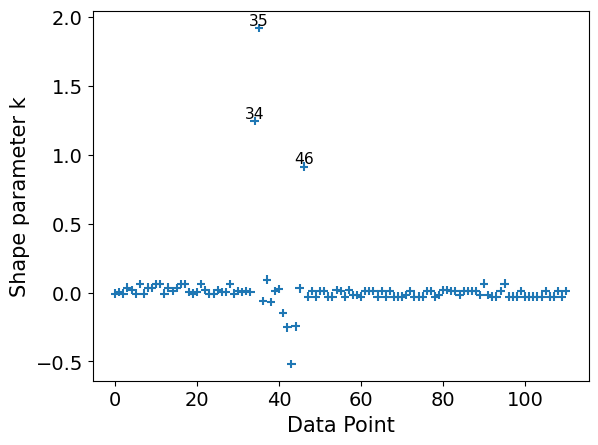

In [23]:
az.plot_khat(loo_p, threshold=0.7);

Si bien la función principal de LOO es comparar modelos, los valores de k puede ser útiles incluso si solo tenemos uno. Por ejemplo podriamos tener conocimiento extra que nos indique por qué estas observaciones son influyentes, quizá hubo un problema en la toma de datos y los valores son incorrectos. O quizá los valores son correctos pero desde la perspectiva de nuestro modelo son influyentes, "extraños", "sorprendentes".

 Si k > 0.7, el valor de p_loo puede darnos algo más de información. Siendo $p$ es el número total de parámetros en un modelo.

* Si p_loo << p entonces el modelo debe estar mal-especificado. Esto debería verse también en las pruebas predictivas a posteriori. Una solución es usar un modelo sobredispersado (como cambiar una poisson por una negativebinomial o por una ZeroInflatedPoisson o HurdlePoisson, o cambiar una Normal por una T de Student, etc). O es probable que el modelo necesite más estructura o complejidad, quizá necesitamos un término no-lineal, etc

* Si p_loo < p y las observaciones son relativamente pocas comparadas con $p$, (digamos p>N/5). Es probable que tengamos un modelo demasiado flexible y/o priors demasiado vagos. Esto puede pasar para modelos jerárquicos con muy pocas observaciones por grupo o por ejemplo para splines con muchos nudos o Procesos Gaussianos con valores de escala muy cortos

* If p_loo > p, entonces el modelo tiene problemas muy serios. Si p<<N, entonces las pruebas predictivas a posterior también deberían reportar problemas. Si en cambio p es relativamente grande (digamos p>N/5). Entonces es posible que las pruebas predictivas a posteriori no reflejen problemas.


Por último, otra forma de usar LOO incluso en ausencia de otro modelo es mediante `plot_loo_pit`. Si el gráfico luce similar al que vimos para los valores p-bayesianos marginales, es por que estamos haciendo lo mismo. Pero esta vez al usar LOO, estamos considerando:



$$
p(\tilde y_i \le y_i \mid y_{-i})
$$

Es decir estamos evaluando, de forma aproximada, la capacidad del modelo de predicir una observación cuando removemos esa observación de los datos observados. 

<Axes: xlabel='acc'>

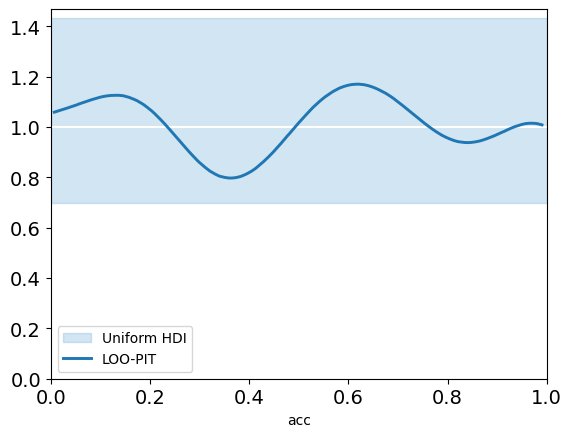

In [24]:
az.plot_loo_pit(idata_cat, y="acc", use_hdi=True)

#### Otros criterios de información

Otro criterio de información muy usado es DIC, si usamos el *bayesómetro™*, DIC es más bayesiano que AIC pero menos que WAIC. Aunque aún es popular, WAIC y principalmentete LOO han demostrado ser más útiles tanto teóricamente como empíricamente que DIC. Por lo cual NO recomendamos su uso.

Otro criterio muy usado es BIC (del inglés Bayesian Information Criteria), al igual que la regresión logística y la *sopa seca* de mi madre, este nombre puede ser engañoso. BIC se propuso como una forma de corregir algunos de los problemas con AIC y el autor propuso una justificación Bayesiana para ello. Pero BIC no es realmente Bayesiano en el sentido que al igual que AIC asume priors *planos* y utiliza una estimación por máxima verosimilitud.

Pero lo que es más importante, es que BIC difiere de AIC y WAIC en su objetivo. AIC y WAIC intentan reflejar cual modelo generaliza mejor a otros datos (exactitud predictiva) mientras que BIC intenta identificar cual es el modelo _correcto_ y por lo tanto está más relacionado los factores de Bayes que con WAIC. Más adelante discutiremos Factores de Bayes y veremos como se diferencia de criterios como WAIC y LOO.

(49.3512138332143, 38.03505923879927)

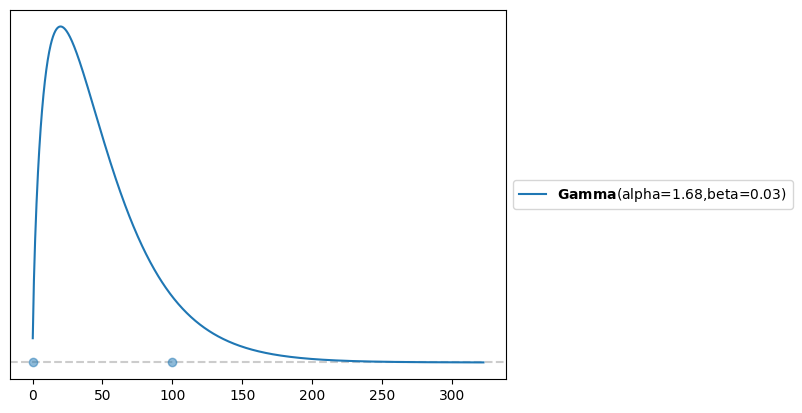

In [25]:
dist= pz.Gamma()
pz.maxent(dist, 0, 100, 0.9)
dist.mu,  dist.sigma

In [26]:
target = pz.StudentT(nu=3, mu=0, sigma=1).rvs(200)

with pm.Model() as modelo_n:
    μ = pm.Normal("μ", 0, 1)
    σ = pm.HalfNormal("σ", 1)
    pm.Normal("y", μ, σ, observed=target)
    idata_n = pm.sample(idata_kwargs={"log_likelihood":True})
    
with pm.Model() as modelo_t:
    μ = pm.Normal("μ", 0, 1)
    σ = pm.HalfNormal("σ", 1)
    ν = pm.Exponential("ν", scale=30)
    pm.StudentT("y", nu=ν, mu=μ, sigma=σ, observed=target)
    idata_t = pm.sample(idata_kwargs={"log_likelihood":True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━  94% 0:00:01 / 0:00:12

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ν]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [27]:
cmp_df = az.compare({'modelo_n':idata_n, 'modelo_t':idata_t})
cmp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
modelo_t,0,-350.379423,2.802802,0.000000,1.0,14.846102,0.000000,False,log
modelo_n,1,-366.544635,3.486939,16.165212,0.0,16.467945,6.353895,False,log


En las filas tenemos los modelos comparados y en la columnas tenemos

* rank : el orden de los modelos (de mejor a peor)
* elpd : la estimación puntual del elpd usando
* p : los parámetros efectivos
* elpd_diff : la diferencia entre el ELPD del mejor modelo y los demás modelos
* weight : el peso relativo de cada modelo. Si quisieramos hacer predicciones combinando los distintos modelos, en vez de elegir uno solo, este sería el peso que deberíamos asignar a cada modelo. En este caso vemos que el modelo polinomial se lleva todo el peso.
* se : el error estándard del ELPD
* dse : el error estándard de las difencias
* warning : una advertencia sobre valores de k altos
* scale : la escala en la que se calcula el ELPD

También podemos obtener más o menos la misma información de forma gráfica usando la función `az.compareplot

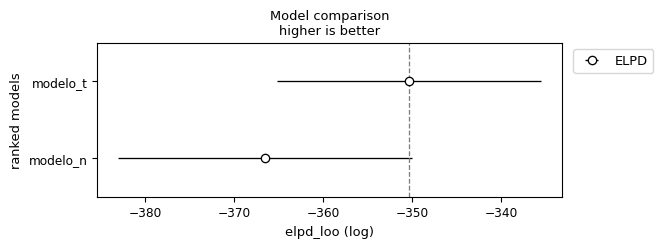

In [28]:
az.plot_compare(cmp_df, plot_ic_diff=False);

* Los círculos vacíos representan los valores del ELPD y lineas negras el error estándar.
* El valor más alto del ELPD se indica con una línea gris discontinua vertical para facilitar la comparación con otros valores.
* Para todos los modelos, excepto *el mejor*, también obtenemos un triángulo que indica el valor de la diferencia del ELPD entre cada modelo y el *mejor* modelo. La barra de error gris que indica el error estándar de las diferencias entre las estimaciones puntuales.

La forma más sencilla de utilizar los criterios de información es elegir un único modelo. Simplemente elija el modelo con el valor más alto de ELPD. Si seguimos esta regla tendremos que aceptar que el modelo cuadrático es el mejor. Incluso si tenemos en cuenta los errores estandar podemos ver que estos no se solapan. Lo que nos da cierta seguridad que efectivamente los modelos son *diferentes* entre si. Si, en cambio, los errores estándar se superpusieran, deberíamos proporcionar una respuesta más matizada.

## Diagnosticos del muestreo por MCMC

### Trace plots

Este es un gráfico muy común. Para cada parámetro graficamos su valor (eje-y) en cada iteración (eje-x). Lo esperable es no ver ningún patrón, solo ruido como en primer panel de la siguiente figura (marco turquesa).

<center><img src=diapo/img/trace_single_good_bad.png width=800></center>

En cambio los otros tres paneles (marco magenta) muestran problemas. De izquierda a derecha y arriba a abajo:

* El segundo panel muestra que el muestreo es "pegajoso", le toma muchos pasos a la cadena moverse de valores altos a valores bajos, es difícil predecir que sucedería si seguimos corriendo, la cadena se movería hacia arriba nuevamente, se estabilizaría en valos bajos, continuaría bajando aún más?

* El tercer panel muestra una cadena menos "pegajosa", pero también daría la impresión que aún no ha terminado de estabilizarse

* El último panel, en cambio, muestra que hay una región donde el sampler se mueve bien, pero cada tanto "salta" a estados donde se queda atascado. Quizá esto se deba a una distribución a posteriori multimodal o dificultades en el sampler para explorar regiones con distinta curvatura. 

Como ya vimos por defecto PyMC corre más de una cadena, por lo que un traceplot ideal debería verse como esto:


<center><img src=diapo/img/trace_multiple_good.png width=800/></center>


ArviZ permite graficar trace-plots usando la función `az.plot_trace()`. Por defecto obtenemos el trace a la derecha y un KDE (para variables continuas) y un histograma (para discretas) a la izquierda

<center><img src=diapo/img/trace_multiple_good_arviz.png width=900 /></center>


### Rank plots 

Los trace plots son muy comunes, pero existe una alternativa más moderna llamada rank plots. La idea básica es la siguiente. Para un parámetro tomamos todas las cadenas y ordenamos los valores de menor a mayor y les asignamos un rango es decir al valor más bajo le ponemos 0, al que sigue 1 y así hasta llegar a un número que será igual a la cantidad de muestras totales (cantidad de cadenas multiplicado por la cantidad de muestras por cadena). Luego reagrupamos los rankings según las cadenas que les dieron origen y para cada cadena hacemos un histograma. Si las cadenas fuesen indistinguibles esperariamos que los histogramas sean uniformes. Ya que no hay razón para que una cadena tenga más rankings bajos (o medios o altos) que el resto.

La siguiente figura muestra 4 ejemplos, donde solo uno (marco cyan) no muestra problemas


<center><img src=diapo/img/rankbar_single_good_bad.png width=800></center>

En ArviZ los rank plots se pueden obtener con la función `az.plot_rank` o pasando un argumento a plot_trace `az.plot_trace(⋅, kind="rank_bars")`

### $\hat R$  (R sombrero)

Los gráficos suelen ser útiles para descrubir patrones, pero aveces queremos números, por ejemplo al evaluar rápidamente mucho parámetros. $\hat R$ es la respuesta a la pregunta. Lograron las cadenas mezclarse adecuadamente? Pero también me gusta pensarlo como el jurado en un concurso de trace (o rank) plots. La versión implementada en ArviZ hace varias cosas debajo del capot, pero la idea central es que compara la varianza *entre* cadenas con la varianza *dentro* de cada cadena.


<center><img src="diapo/img/r_hat.gif" width=900></center>

Idealmente $\hat R = 1$, en la práctica $\hat R \lessapprox 1.01$ son considerados seguros y en la primer fase de modelado valores más altos como $\hat R \approx 1.1$ pueden estár bien.

Usando ArviZ podemos obtener $\hat R$ usando `az.rhat(⋅)`, `az.summary(⋅)` y `az.plot_forest(⋅, r_hat=True)`

### Gráfico de autocorrelación

Idealmente, una muestra debe ser independiente e idénticamente distribuida (iid). Por definición, las muestras MCMC están correlacionadas. En la práctica, queremos muestras con baja autocorrelación. En ArviZ obtenemos este gráfico con la función `az.plot_autocorr()`

cadenas_defectuosas = {"cadenas_defectuosas": np.linspace(0, 1, 1000).reshape(2, -1)}
az.plot_autocorr(cadenas_defectuosas);

cadenas_adecuadas = {"cadena_adecuadas": pz.Uniform(0, 1).rvs(size=(2, 500))}
az.plot_autocorr(cadenas_adecuadas);

### Tamaño de muestra efectivo (ESS)

Como las muestras de un MCMC están correlacionadas la cantidad de información "útil" es menor que una muestra del mismo tamaño pero iid.

<br>
<br>
<center><img src="diapo/img/ess.gif" width=600></center>


Podemos estimar el **tamaño de muestra efectivo** (ESS), es decir, el tamaño de una muestra con la cantidad equivalente de información pero sin autocorrelación. Esto es útil para determinar si la muestra que tenemos es lo suficientemente grande. Se recomienta que el ESS sea superior a 100 por cadena. Es decir para para 4 cadenas queremos un mínimo de 400.

Con ArviZ podemos obtenerlo `az.ess(⋅)`, `az.summary(⋅)` y `az.plot_forest(⋅, ess=True)`

pd.concat((az.ess(cadenas_defectuosas).to_pandas(),
           az.ess(cadenas_adecuadas).to_pandas()))

Vemos que `az.summary(⋅)` devuelve dos valores de ESS, `ess_bulk` y `ess_tail`. Esto se debe a que, distintas regiones del espacio de los parámetros pueden tener distinto valor de ESS, ya que no todas las regiones son muestreadas con la misma eficiencia. Intuitivamente uno puede pensar que al muestrear una distribución como una Gaussiana es más fácil obtener mejor calidad de muestra alrededor de la media que de las colas, simplemente por que tenemos más muestras de esa región.

pd.concat([az.summary(cadenas_adecuadas, kind="diagnostics"),
           az.summary(cadenas_defectuosas, kind="diagnostics")])

Si las muestras de MCMC las vamos a usar para calcular valores centrales como medias o medianas entonces tenemos que asegurarnos que el `ess_bulk` sea lo suficientemente algo, en cambio, si queremos calcular intervalos como un HDI 95% hay que asegurarse que `ess_tail` sea adecuado.

ArviZ ofrece varias funciones vinculadas al ESS. Por ejemplo si queremos evaluar el desempeño del sampler para varias regiones al mismo tiempo podemos usar `az.plot_ess`.

NameError: name 'cadenas_adecuadas' is not defined

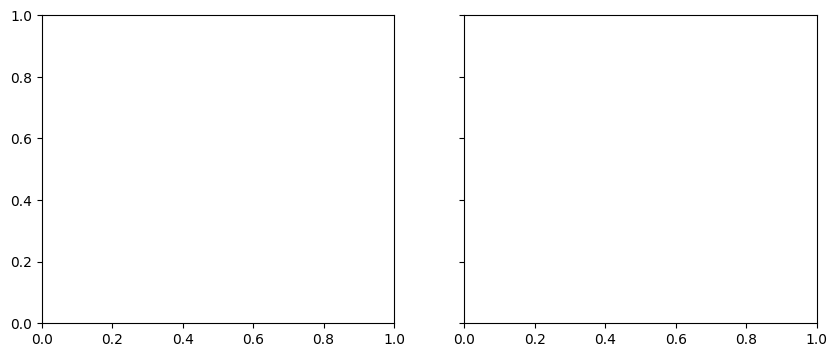

In [29]:
_, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
az.plot_ess(cadenas_adecuadas, ax=axes[0])
az.plot_ess(cadenas_defectuosas, ax=axes[1]);

Una forma simple de aumentar el ESS es aumentar la cantidad de muestras, pero podría darse el caso que el ESS crezca muy lento con el número de muestras, por lo que aún si aumentaramos 10 veces la cantidad de muestras estaríamos por debajo de lo requerido. Una forma de estimar "cuanto nos falta" es usar `az.plot_ess(⋅, kind="evolution")`. Este gráfico nos muestra como fue cambiando el ESS con cada muestra, lo que nos permite hacer proyecciones. En el siguiente ejemplo vemos que para `cadenas_adecuadas` el ESS crece lineamente con el número de muestras mientras que para `cadenas_defectuosas` no crece para nada. Este último caso no hay esperanzas de mejorar el ESS simplemente aumentando la cantidad de muestras.

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
az.plot_ess(cadenas_adecuadas, kind="evolution", ax=axes[0])
az.plot_ess(cadenas_defectuosas,  kind="evolution", ax=axes[1]);

### Error estándard del Monte Carlo (MCSE)

Una ventaja del ESS es que no tiene escala, da igual si un parámetro varía entre 0.1 y 0.2 y otro entre -2000 y 5000, un ESS de 400 tiene el mismo significado en ambos casos. En modelos con muchos parámetros rápidamente podemos indentificar cuales parámetros son más problemáticos. Sin embargo, a la hora de reportar resultados no es muy informativo saber si el ESS fue de 1372 o 1501. En cambio nos gustaría saber el orden del error que estamos cometiendo al aproximar la distribución a posterori. Esa información la da el **error estándard del Monte Carlo** (MCSE). Al igual que el ESS, el MCSE tiene en cuenta la autocorrelación de las muestras. Este error debe estar por debajo de la precisión deseada en nuestros resultados. Es decir si para un parámetro el MCSE es 0.1, no tiene sentido reportar que la media de ese parámetro es 3.15. Ya que tranquilamente el valor correcto podría estar entre 3.4 y 2.8.

Una de las cantidades devueltas por `az.summary(⋅)` es mc_error.

## Diagnóstico de algoritmos basados en gradiente

Debido a su funcionamiento interno, algoritmos como NUTS  ofrecen algunas pruebas específicas que no están disponibles para otros métodos. Generalmente estas pruebas son muy sensibles

Para ejemplificar esto vamos a cargar dos InferenceData de modelos pre-calculados. Los detalles de como se generaron estos idatas no son relevantes por el momento. Solo diremos que son dos modelos que son matemáticamente equivalente pero parametrizados de formas distintas. En este caso la parametrización afecta la eficiencia del sampler. El modelo `centrado` es muestreado de forma más eficiente que el modelo `no centrado`.

idata_cm = az.load_arviz_data("centered_eight")
idata_ncm = az.load_arviz_data("non_centered_eight")

### Energía de transición vs energía marginal

Podemos pensar en un Monte Carlo Hamiltoniano como un proceso de dos pasos  
* Un muestreo determinista (siguiendo el hamiltoniano)  
* Una caminata aleatorio en el espacio del momentum

Si la distribución de la energía de transición es similar a la distribución de la energía marginal, entonces NUTS es capaz de generar muestras de la distribución marginal de la energía que sean *casi* independientes entre transiciones. Esto lo podemos evaluar visualmente o numéricamente, calculando el Bayesian Fraction of Missing Information (BFMI), como se muestra en la siguiente figura.


In [ ]:
_, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 4), constrained_layout=True)

for ax, idata, nombre in zip(axes.ravel(), (idata_cm, idata_ncm), ("centrado", "no centrado")):
    az.plot_energy(idata, ax=ax)
    ax.set_title(nombre)

### Divergencias

Una ventaja de NUTS es que *falla con el estilo*. Esto sucede por ejemplo al intentar pasar de regiones de baja curvatura a regiones de alta curvatura. En estos casos las trayectorias numéricas pueden divergir. En esencia esto sucede por que en esos casos no existe un único conjunto de hiper-parámetros que permita el muestreo eficiente de ambas regiones. Por lo que una de la regiones es muestreada adecuandamente y cuando el sampler se mueve hacia la otra región falla. Las trayectorias numéricas divergentes son identificadores extremadamente sensibles de *vecindarios patológicos*.

El siguiente ejemplo muestra dos cosas el modelo `no centrado` muestra varias divergencias (círculos turquesas) agrupados en una región. En el modelo `centrado`, que no tiene divergencias, se puede ver que alrededor de esa misma región hay muestras para valores más pequeños de `tau`. Es decir el modelo `no centrado` falla en muestrear una región, pero al menos avisa que está teniendo problemas en muestrear esa región!

In [ ]:
_, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5), constrained_layout=True)


for ax, idata, nombre in zip(axes.ravel(), (idata_cm, idata_ncm), ("centrado", "no_centrado")):
    az.plot_pair(idata, var_names=['theta', 'tau'], coords={'school':"Choate"}, kind='scatter',
                 divergences=True, divergences_kwargs={'color':'C1'},
                 ax=ax)
    ax.set_title(nombre)

In [ ]:
az.plot_parallel(idata_cm, figsize=(12, 4));

## Qué hacer cuando los diagnósticos no dan bien?

<br>

* <font color = gray> Más muestras o más pasos de tuning. Esto solo suele ser útil cuando los problemas son menores</font>

* <font color = gray> Burn-in. Software moderno como PyMC utiliza una cantidad de muestras para ajustar los hiper-parámetros de los métodos de muestreo. Por defecto esas muestras son eliminadas, por lo que en general no es necesario hacer Burn-in manualmente. </font>

* <font color = gray> Cambiar el método de muestreo! </font>


* Reparametrizar el modelo

* <font color = orange> Mejorar las distribuciones _a priori_ </font>
    * El _teorema popular_ de la estadística computacional: Cuando tienes problemas computacionales, a menudo hay un problema con tu modelo. La recomendación NO es cambiar la distribución _a priori_ para mejorar la calidad del muestreo. La recomendación es que si el muestreo es malo, quizá el modelo también lo sea. En ese caso, podemos pensar en mejorar el modelo, una forma de mejorarlo es usar conocimiento previo para mejorar las distribuciones _a priori_.

* Algunos modelos pueden expresarse en más de una forma, todas matemáticamente equivalentes. En esos casos, algunas parametrizaciones pueden ser más eficientes que otras. Por ejemplo, como veremos más adelante con modelos lineales jerárquicos.

* En el caso de las divergencias, estas suelen eliminarse aumentando la tasa de aceptación (`pm.sample(..., target_accept=x)` x>0.8)

* Leer los mensajes de advertencia y sugerencias de PyMC!   ;-)

## A Blueprint for Effective Bayesian Workflows

We have collected in a single place all these tips and recommendations so you can get a quick reference. All these steps will be developed with examples in the next X chapters. Here we write the recommendations linearly, but in practice, you may need to come back one or more steps and sometimes skip steps. Think of these notes, not as a partiture of a classical piece that a violinist has to follow exactly, but as the partiture that a Jazz bassist follows, you are free to improvise, rearrange some parts, and omit others, and you can even add your notes!


### Summarize the problem 

Summarize the key points of your problem, and what you would like to learn from the data. Think also about others, what your boss, client, or colleague would like to find out or learn. This does not need to be super thorough, you can revisit goals later, but they can help you organize your modeling efforts and avoid excessive wandering.

Sometimes you will not have any clear idea of what to expect or what to do, your only expectation will be to get something useful from a dataset, and that's fine. But other times you may even know what kind of model you want, perhaps your boss explicitly asked you to run this or that analysis. If you already know what kind of problem you want to solve, but are not very familiar with the approach, search for what methods, metrics or visualizations are common for that problem/data, and ask others for advice. This is more important the less familiar you are with that type of problem/data. If you are familiar, then you may already know which methods, visualizations, and summaries you want to use or obtain. Either way write an outline, a roadmap to help you keep the focus. 


::: {.callout-tip appearance="simple"}
## Tips for Success
* Communicate often with your stakeholders
    * Ask many questions and ensure you and them have the same understanding
* Understand if more data is coming in later or if this is it
  * This will inform you if you'll need to repeat the workflow if things change
* Set preliminary expectations of what is possible
:::


### Get familiar with the data

It is always a good idea to perform Exploratory Data Analysis on your data. Blindly modeling your data leads you to all sorts of problems.
Taking a look first will save you time and may provide useful ideas. Sometimes it could even save you from having to write a Bayesian model at all, perhaps the answer is a scatter plot! 

When exploring the data we want to make sure, we get a really good understanding of it. How to achieve this can vary a lot from dataset to dataset and from analysis to analysis. But there are useful sanity checks that we usually do, like checking for missing values, or errors in the data. Are the data types correct? Are all the values that should be numbers, numbers (usually integers or floats) or they are strings? Which variables are categorical? Which ones are continuous? At this stage, you may need to do some cleaning of your data. This will save you time in the future.

Usually, we would like to also do some plots, histograms, boxplots, scatter plots, correlations matrices, etc. Besides plots also compute numerical summaries, mean, and medians, for all your data, or by grouping the data, etc.

::: {.callout-tip appearance="simple"}
## Tips for Success
* Spend more time doing EDA than you may think you need
    * Be organized, you'll likely need to refer to these plots later on during modeling or presentation phases
* Store your data in a secure place referenceable place
  * CSVs on computers are easy to lose track of
:::

### Tell a story for the data

It is often helpful to think about how the data could have been generated. This is usually called the data-generating process or data-generating mechanism. We don't need to find out the True mechanism, many times we just need to think about plausible mechanisms.

Make drawings, and try to be very schematic, doodles and geometrical figures should be enough unless you are a good sketcher. This step can be tricky, so let us use an example. Let's say you are studying the water levels of a lake, think about what makes the water increase; rain, rivers, etc, and what makes it decrease; evaporation, animals drinking water, energy production, etc. Try to think which of these elements may be relevant and which one could be negligible. Use as much context as you have for your problem.

Try to keep it simple but not simpler. For instance, a mechanism could be "Pigs' weight increases the more corn they are fed", that's a good mechanism if all you need to predict are your earnings from selling pigs. But it will be an oversimplistic mechanism if you are studying intestine absorption at the cellular level.

If you can think of alternative stories and you don't know how to decide which one is better. Don't worry, list them all! Maybe we can use the data to decide!

### Write a model

Try to translate the data-generating mechanism into a model. If you feel comfortable with math, use that. If you prefer a visual representation like a graphical model, use that. If you like code, then go for it. Incomplete models are fine as a first step. For instance, if you use code, feel free to use pseudo code or add comments to signal missing elements as you think about the model. You can refine it later.

Try to start simple, don't use hierarchies, keep prior 1D (instead of multivariate), skip interactions for linear models, etc. If for some reason you come first with a complex model, that's ok, but you may want to save it for later use, and try with a simplified version. 

Sometimes you may be able to use a standard textbook model or something you saw on a blog post or a talk. It is common that for certain problems people tend to use certain "default" models. That may be a good start, or maybe all you need. keep things simple, unless you need something else. 

This is a good step to think about your priors, not only which family are you going to use, but what specific parameters. If you don't have a clue just use some vague prior. But if you have some information use it. Try to encode very general info,  like this parameter can not be negative, or this parameter is likely to be smaller than this, or within this range. Look for the low-hanging fruit, usually that will be enough. The exception will be when you have enough good quality information to define a very precise prior, but even then, that's something you can add later.

### Implement the model

Write the model in a probabilistic programming language. If you used code in the previous example the line between this step and the previous one, may be diffuse, that's fine. Try to keep the model simple at first, we will add more layers later as we keep iteration through this workflow. Starting simple usually saves you time in the long run. Simple models are easier to debug and debugging one issue at a time is generally less frustrating than having to fix several issues before our model even runs. 

Once you have a model, check that the model compiles and/or runs without error. When debugging a model, especially at an earlier stage of the workflow, you may want to work with a reduced dataset, like reducing the dataset by 50 or 90% if the dataset is too large, or maybe start with just a few covariables, and then add the rest. This can help speed up the model, so you can change the model and iterate faster. This has the downside that you may miss the necessary data to uncover some relevant pattern but it could be ok at the very beginning, when it is usually the time you will make most of the mistakes or have bigger doubts about what you are doing. In the early stages, you can also reduce the number of tuning and sampling steps. 

### Evaluate prior predictive distribution

It is usually a good idea to generate data from the prior predictive distribution and compare that to your prior knowledge. Does the bulk of the simulated distribution in a resonable range? Are there any extreme values? Use reference values as a guide. Reference values are empirical data or historical observations, usually, they will be minimum, maximum or expected values. Avoid comparing with the observed data, as that can lead to issues if you are not careful enough. 

### Compute posterior
There are many ways to compute the prior, in this guide we assume the use of MCMC methods as they are the most general method and the most commonly used method to estimate posterior in modern Bayesian analysis.


### Evaluate samples

When using MCMC methods, we need to check that the samples are good enough. For this, we need to compute diagnostics such as  $\hat R$ (r-hat) and effective sample size (ESS). And evaluate plots such as traceplot and rankplots. Diagnostics don't need to be that good at the early stages of the workflow. At the same time, very bad diagnostics could be a signal of a problem with our model(s). 

### Validate the model

There are many ways to validate your model, like a posterior predictive check, Bayesian p-values, residual analysis, recovery parameters from synthetic data (or the most costly simulated-based calibration). Or a combination of all of this. Sometimes you may be able to use a holdour set to evaluate the predictive performance of your model. The main goal here is to find if the model is good enough for your purpose and what limitations the model can have. All models will have limitations, but some limitations may be irrelevant in the context of your analysis, some may be worth removing by improving the models, and others are simply worth knowing they are there. 

### Compare models

If you manage to get more than one model (usually a good idea), you may need to define which one you would like to keep (assuming you only need one). To compare models you can use cross-validation and/or information criteria. But you can also use the results from the previous step (model validation). Sometimes we compare models to keep a single model, model comparison can also help us to better understand a model its strengths and its limitations, and it can also be a motivation to improve a model or try a new one. Model averaging, i.e. combining several models, is usually a simple an effective strategy to improve predictive performance.

### Summarize results

Summarize results in a way that helps you reach your goals, did you manage to answer the key questions? Is this something that will convince your boss or the marketing department? Think of effective ways to show the results. If your audience is very technical do a technical summary, but if your audience only cares about maximizing profit focus on that. Try to use summaries that are easy to understand without hiding valuable details, you don't want to mislead your audience.


## Closing remarks

Note: Less hyperbolic than before, but still not happy with this.

In conclusion, we emphasize once again that the Bayesian workflow is not a rigid set of instructions but a dynamic and evolving approach to modeling. Think of it as a conceptual framework guiding your thoughts and actions in the pursuit of better models and analyses.

The methods, tools, and practices for Bayesian analysis will improve over time. As technology advances, we expect automation through software tools, and this guide will evolve accordingly.

Furthermore, the Bayesian workflow underscores the importance of valuing the journey as much as the destination. It fosters a deeper understanding of the problem and enhances skills applicable across various domains. Ultimately, the Bayesian workflow represents a commitment to ongoing learning and refinement in modeling and analysis.

## Distribución predictivas 

Si bien el objeto central de la estadística Bayesiana es la distribución _a posteriori_. Existen otras distribuciones muy importantes. Una de ellas es la distribución predictiva _a posteriori_, otra es la distribución predictiva _a priori_. 


### Distribución predictivas  _a posteriori_


Esta distribución representa las predicciones $\tilde{y}$ de un modelo una vez obtenido el _a posteriori_. Se calcula de la siguiente manera:

$$
p(\tilde{y}  \mid  y) = \int p(\tilde{y} \mid \theta) p(\theta \mid y) d\theta 
$$

Es decir integramos $\theta$ de acuerdo a la distribución _a posteriori_. 

Computacionalmente podemos generar muestras de esta distribución según el siguiente procedimiento:

1. Elegimos un valor de $\theta$ de acuerdo a la distribución a posteriori $p(\theta \mid y)$
2. Fijamos $\theta$ en la distribución que usamos como likelihood $p(\tilde{y} \mid \theta)$ y generamos una muestra aleatoria
3. Repetimos desde 1, tantas veces como muestras necesitemos

Los datos generados son predictivos ya que son los datos que se esperaría ver por ejemplo en un futuro experimento, es decir son variables no observadas pero potencialmente observables. Como veremos en el siguiente capítulo un uso muy común para la distribución predictiva _a posteriori_ es compararla con los datos observados y así evaluar si el posterior calculado es razonable.

### Distribución predictiva _a priori_

Asi como es posible generar datos sintéticos desde el _a posteriori_. Es posible hacerlo desde el prior. En este caso la distribución se llama distribución predictiva _a priori_. Y representa los datos $p(Y^\ast)$ que el modelo *espera* ver antes de haber visto los datos. O más formalmente antes de haber sido condicionado a los datos. Se calcula como:

$$
p(Y^\ast) =  \int_{\Theta} p(Y^\ast \mid \theta) \; p(\theta) \; d\theta
$$

Es importante notar que la definición es muy similar a la distribución predictiva a posteriori, solo que ahora integramos a lo largo del prior en vez del posterior.

Los datos generados son predictivos ya que son los datos que el modelo esperara ver, es decir son datos no observados pero potencialmente observables. Como veremos en el siguiente capítulo un uso muy común para la distribución predictiva _a priori_ es compararla con nuestro conocimiento previo y así evaluar si el modelo es capaz de generar resultados razonable, incluso antes de haber incorporado los datos.

### Distribución predictiva _a priori_ y a posterior para el problema de la moneda.

En el caso del modelo beta-binomial es posible obtener analíticamente tanto la distribución predictiva a priori como a posteriori y estas son:

$$
p(Y^\ast) \propto \operatorname{Beta-binomial}(n=N, \alpha_{a priori}, \beta_{a priori})
$$


$$
p(\tilde{Y}  \mid  Y)  \propto \operatorname{Beta-binomial}(n=N, \alpha_{a priori} + y, \beta_{a priori} + N - y)
$$

Omitiremos la discusión de como se obtienen estas distribuciones

### Cuarteto Bayesiano

El siguiente bloque de código computa las distribuciones _a priori_, _a posteriori_, predictiva _a priori_ y predictiva _a posteriori_. En vez de usar la distribución $\operatorname{Beta-binomial}$ para las distribuciones predictivas hemos optado por usar una aproximación más computacional y muestrear primero de la distribuciones beta y luego de la binomial. Esperamos que esta decisión contribuya a comprender mejor que representan estas distribuciones.


Es importante notar que mientras la distribuciones _a priori_ y _a posteriori_ son distribución **sobre los parámetros en un modelo**, la distribución predictivas _a priori_ y _a posteriori_ son distribuciones **sobre los datos** (predichos).

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex="row", sharey="row")
axes = np.ravel(axes)
dist = pz.Beta
a_prior = 1
b_prior = 1
N = 12
y = 3
x = np.linspace(0, 1, 100)


prior = dist(a_prior, b_prior).pdf(x)
axes[0].fill_between(x, 0, prior)
axes[0].set_title("Prior")
axes[0].set_yticks([])


posterior = dist(a_prior + y, b_prior + N - y).pdf(x)
axes[1].fill_between(x, 0, posterior)
axes[1].set_title("Posterior")


prior = dist(a_prior, b_prior).rvs(500)
prior_predictive = np.hstack([pz.Binomial(n=N, p=p).rvs(N) for p in prior])
axes[2].hist(prior_predictive, bins=range(0, N+2), rwidth=0.9, align="left", density=True)
axes[2].set_title("Prior predictive")

posterior = dist(a_prior + y, b_prior + N - y).rvs(500)
prior_predictive = np.hstack([pz.Binomial(n=N, p=p).rvs(N) for p in posterior])
axes[3].hist(prior_predictive, bins=range(0, N+2), rwidth=0.9, align="left", density=True)
axes[3].set_title("Posterior predictive");

fig.suptitle("Cuarteto Bayesiano", fontweight="bold", fontsize=16);

## Resumen

Empezamos este capítulo con una breve discusión sobre el modelado estadístico y la teoría de la probabilidad y teorema de Bayes que se deriva de ella. Luego utilizamos el problema de la moneda como una excusa para introducir aspectos básicos del modelado Bayesiano y el análisis de datos. Utilizamos este ejemplo clásico para transmitir algunas de las ideas más importantes de las estadística Bayesiana, fundamentalmente el uso de distribuciones de probabilidad para construir modelos y representar la incertidumbre. Tratamos de desmitificar el uso de los _a prioris_ dándoles el mismo estatus epistemológico-metodológico que otros elementos que forman parte del proceso de modelado e inferencia, como el _likelihood_ o incluso meta-preguntas, ¿Por qué me interesa este problema en particular? Concluimos el capítulo con una breve y simple descripción de cómo interpretar y comunicar los resultados de un análisis bayesiano.


La siguiente figura, inspirada en una figura de [Sumio Watanabe](https://www.crcpress.com/Mathematical-Foundations-of-Bayesian-Statistics/Watanabe/p/book/9781482238068) resume el _flujo de trabajo Bayesiano_ tal cual se describió en este capítulo. 

<center>
<img src="img/bayesian_workflow.png" width=500 class="center">
</center>
    
1. Suponemos que existe una distribución _verdadera_ que, en general, es desconocida (ya sea en la práctica o intrínsecamente). De esta distribución se obtiene una muestra finita, ya sea haciendo un experimento, una encuesta, una observación, una simulación, etc.
2. A partir de la muestra realizamos una inferencia Bayesiana obteniendo una distribución _a posteriori_. Esta distribución es el objeto central de la estadística Bayesiana ya que contiene toda la información sobre un problema (de acuerdo al modelo y los datos).
3. Una cantidad que podemos derivar del _a posteriori_ es la distribución predictiva _a posteriori_, es decir predicciones. Una forma de evaluar un modelo es comparar la distribución predictiva _a posteriori_ con la muestra finita que obtuvimos en primer lugar.

La figura anterior es muy general y omite varios pasos, pero contiene la idea esencial que el modelado es un proceso iterativo. En los siguientes capítulo, veremos como sumar nuevos pasos, como que hacer cuando tenemos más de un modelo y profundizar sobre estos pasos y lo aprendido en este capítulo

## Pruebas predictivas a posteriori

La prueba consiste en comparar los datos observados con los datos predichos a partir del _a posteriori_. 

Las pruebas predictivas _a posteriori_ son pruebas de auto-consistencia. Este ejercicio nos permite evaluar si el modelo es razonable, la idea general no es determinar si un modelo es _correcto_ o no ya que como dijo George Box _"todos los modelos están equivocados, pero algunos son útiles"_. El grado de confianza en la _verosimilitud_ de los modelos ciertamente es distinta entre practicantes de distintas disciplinas científicas, en disciplinas como física cuando se estudian sistemas relativamente simples bajo condiciones experimentales extremadamente controladas y haciendo uso de _teorías fuertes_, es probable que se le asigne un alto grado de confianza a ciertos modelos. Pero esto no suele ser cierto en disciplinas como ciencias sociales o biología (aunque sospecho que la variabilidad encontrada en biología ¡es muy alta!). En el caso de contar con _a prioris_ muy informativos la evaluación de un modelo también puede ser usado para evaluar si los propios datos son razonables, indicando que tal vez sea necesario conseguir nuevos datos o revisar como se obtuvieron los datos o como se procesaron. 

En definitiva la principal utilidad de las pruebas predictivas _a posteriori_ debería ser el permitirnos dar una segunda mirada, crítica, al modelo y tratar de entender la razón de discrepancias sistemáticas (si las hubiera), estas discrepancias nos pueden llevar a entender mejor los límites del modelo, abandonar el modelo por completo o tal vez mejorarlo.

Si bien se han desarrollado métodos _formales_ o _cuantitativos_ para realizar pruebas predictivas _a posteriori_, una aproximación que suele ser más informativa y simple de interpretar es realizar gráficas, como veremos a continuación.


Usando PyMC podemos calcular la distribución predictiva a posteriori de la siguiente forma

In [ ]:
idata_cat.extend(
    pm.sample_posterior_predictive(idata_cat, model=modelo_cat, random_seed=1791)
)

Si bien es posible construir nuestras propias pruebas predictivas a posteriori, a continuación usaremos dos funciones de ArviZ.

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_ppc(idata_cat, ax=ax[0])
ax[0].set_xlabel("acc")
az.plot_loo_pit(idata_cat, "acc_observed", ax=ax[1], use_hdi=True)
ax[1].set_yticks([]);

* `az.plot_ppc`: Por defecto esta función representa los datos observados, varias muestras de la distribución predictiva a posteriori (predicciones) y la distribución media de estas muestras. Si los datos son discretos se usan histogramas, si los datos son continuos KDEs.

* `az.plot_loo_pit`: Muestra la diferencia entre datos observados y predichos (linea azul), de tal forma que si no hubiera diferencia obtendríamos una distribución uniforme (linea blanca). En el eje x están los cuantiles de la distribución. Por lo que si hubiera diferencia alrededor de 0.5 esto implica diferencia alrededor de la mediana, si en cambio la diferencia estuviera entre 0 y 0.2 esto implicaría diferencias en la cola izquierda (primer 20% de la masa total de la distribución), etc. Si la curva está por encima de la linea blanca esto quiere decir que hay más observaciones que predicciones en esa región, y si la curva está por debajo lo contrario. El gráfico muestra un banda, que indica las desviaciones esperadas respecto de la distribución uniforme para el tamaño de muestra dado. Cualquier diferencia dentro de esa banda es "esperable".

## Pruebas predictivas _a priori_

Las pruebas predictivas _a prior_ son una forma de evaluar el modelo. Una vez definido un modelo Bayesiano se generan muestras a partir del mismo, pero *sin condicionar* en los datos $\tilde{y}$, es decir se calcula la distribución posible de datos (sintéticos) sin haber visto los datos reales. 

$$
p(y^\ast) =  \int_{\Theta} p(y^\ast \mid \theta) \; p(\theta) \; d\theta
$$

Los datos generados son predictivos ya que son los datos que el modelo esperara ver, es decir son datos no observados pero potencialmente observables. La prueba consiste en comparar los datos observados con el conocimiento previo que tenemos sobre el problema, ojo que NO se trata de comparar con los datos observados! 

Las pruebas predictivas _a priori_ son pruebas de consistencia con nuestro conocimiento previo. Este ejercicio nos permite evaluar si el modelo es razonable, en el sentido de si es capaz de generar datos que concuerdan con lo que sabemos de un problema. Por ejemplo un modelo del tamaño de planetas no es muy razonable si predice planetas de escala nanométrica o incluso de unos pocos kilómetros. Es importante destacar que dado suficiente cantidad y calidad de datos un modelo de este tipo podría dar resultados razonables, una vez condicionado a esos datos. Es decir el posterior podría no incluir, o asignar probabilidades despreciables a nanoplanetas.

En definitiva la principal utilidad de las pruebas predictivas _a prior_ es la de permitirnos inspeccionar críticamente un modelo y tratar de entender el comportamiento del modelo las discrepancias con el conocimiento previo nos pueden llevarnos a entender mejor los límites del modelo, abandonar el modelo por completo o tal vez mejorarlo por ejemplo usando priors más angostos u otros likelihoods.

Usando PyMC podemos calcular la distribución predictiva a priori de la siguiente forma

In [ ]:
idata_cat.extend(pm.sample_prior_predictive(model=modelo_cat, random_seed=1791))

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(10, 6), sharey="row", sharex="col")

ax[0, 0].plot(
    años[np.isfinite(accidentes)],
    idata_cat.prior_predictive["acc_observed"].sel(draw=50).squeeze("chain").T,
    ".",
)
a_sample = idata_cat.prior.sel(draw=50)
coco = np.full_like(años, a_sample["t_1"].item(), dtype=float)
coco[a_sample["pc"] >= años] = a_sample["t_0"].item()
ax[0, 0].step(años, coco)
ax[0, 0].set_ylabel("número de accidentes")

az.plot_dist(
    idata_cat.prior_predictive["acc_observed"].sel(draw=50), ax=ax[0, 1], rotated=True
)


ax[1, 0].plot(
    años[np.isfinite(accidentes)],
    idata_cat.prior_predictive["acc_observed"].squeeze("chain").T,
    "C0.",
    alpha=0.05,
)
ax[1, 0].set_ylabel("número de accidentes")
ax[1, 0].set_xlabel("años")

az.plot_dist(idata_cat.prior_predictive["acc_observed"], ax=ax[1, 1], rotated=True)
ax[1, 1].set_xlabel("probabilidad");

La primer fila de la figura anterior muestra una muestra de la distribución predictiva a priori. A la izquierda el número de accidentes por año (puntos azules). Y la tasa media en turquesa mostrando un valor de $\approx 0.3$ antes de 1880 y 1.3 con posterioridad a esa fecha. A la derecha un histograma de la cantidad de accidentes.

La segunda fila muestra lo mismo pero agregado para las 500 muestras que le pedimos a PyMC. Se ve una distribución de accidentes uniforme a lo largo de los años, esto es esperable dado que hemos definido el mismo prior para ambas tasas. Además, podemos ver que nuestro modelo favorece valores relativamente bajos de accidentes por año con el 85% de la masa para valores iguales o menores a 3.


## Ejercicios

1. (Borrador, Está bien esto como ejercicio o lo demostramos en el texto?) Demuestre que la transformada integral de probabilidad es cierta.

1. (Borrador) Usando la transformada integral de probabilidad describa una método general para generar muestreas aleatorias de cualquier distribución a partir de una distribución uniforme.

1. (Borrador) deberíamos tener una serie de ejercicios donde calculen los valores-p marginales para distribuciónes sintéticas, por tomar una Gaussiana de base y comparar con 
* una gaussian más ancha, otra más angosta y otra desplazada y ver en cada caso como la distribución se desvía de la uniforme.